**Aerial Image Processing Using Machine Learning**

**Aim -- Building Segmentation To Aid Machine Learning For Aerial Image Labelling**

Dataset Used -- Massachusetts Buildings Dataset

* Dataset Link -- https://www.kaggle.com/balraj98/massachusetts-buildings-dataset 

**Installing & Upgrading Kaggle**

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=2eb880dbc085ff251bbbe4f4b6ea0819a49af06403c7e031c7ee7b996f1a537d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


**Uploading Kaggle API Key**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hardevkhandhar","key":"98bf9bfde2428469450aaa847339130b"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list -s Massachusetts

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ndalziel/massachusetts-public-schools-data                    Massachusetts Public Schools Data                  337KB  2017-08-22 02:25:43           3037         83  0.85294116       
balraj98/massachusetts-roads-dataset                          Massachusetts Roads Dataset                          6GB  2020-09-26 03:57:49            479         33  0.9411765        
balraj98/massachusetts-buildings-dataset                      Massachusetts Buildings Dataset                      1GB  2020-09-25 06:28:03            146         13  0.9411765        
insaff/massachusetts-roads-dataset                            Massachusetts

**Dataset Download & Unzip**

In [7]:
!kaggle datasets download -d balraj98/massachusetts-buildings-dataset
!ls

 99% 1.48G/1.49G [00:18<00:00, 55.7MB/s]
100% 1.49G/1.49G [00:18<00:00, 86.9MB/s]
kaggle.json  massachusetts-buildings-dataset.zip  sample_data


In [9]:
! unzip massachusetts-buildings-dataset.zip -d data/

Archive:  massachusetts-buildings-dataset.zip
  inflating: data/label_class_dict.csv  
  inflating: data/metadata.csv       
  inflating: data/png/test/22828930_15.png  
  inflating: data/png/test/22828990_15.png  
  inflating: data/png/test/22829050_15.png  
  inflating: data/png/test/23429020_15.png  
  inflating: data/png/test/23429080_15.png  
  inflating: data/png/test/23578960_15.png  
  inflating: data/png/test/23579005_15.png  
  inflating: data/png/test/23729035_15.png  
  inflating: data/png/test/23879080_15.png  
  inflating: data/png/test/24179065_15.png  
  inflating: data/png/test_labels/22828930_15.png  
  inflating: data/png/test_labels/22828990_15.png  
  inflating: data/png/test_labels/22829050_15.png  
  inflating: data/png/test_labels/23429020_15.png  
  inflating: data/png/test_labels/23429080_15.png  
  inflating: data/png/test_labels/23578960_15.png  
  inflating: data/png/test_labels/23579005_15.png  
  inflating: data/png/test_labels/23729035_15.png  
  inflati

**Importing Libraries**

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

**Defining Training / Validation / Testing Directories**

In [3]:
DATA_DIR = '/content/data/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("/content/data/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


**Shortlisting Specific Classes**

In [5]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


**Helper Functions For Data Visualization & One - Hot Encoding / Decoding**

In [6]:
# Helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize = (20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # Get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize = 20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis = -1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.

    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
class BuildingsDataset(torch.utils.data.Dataset):
    """
    Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Arguments:
        images_dir (str) : path to images folder
        masks_dir (str) : path to segmentation masks folder
        class_rgb_values (list) : RGB values of select classes to extract from segmentation mask 
        augmentation (albumentations.Compose) : data transfromation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose) : data preprocessing (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values = None, 
            augmentation = None, 
            preprocessing = None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # One-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # Return length 
        return len(self.image_paths)

**Visualizing Sample Image & Mask**

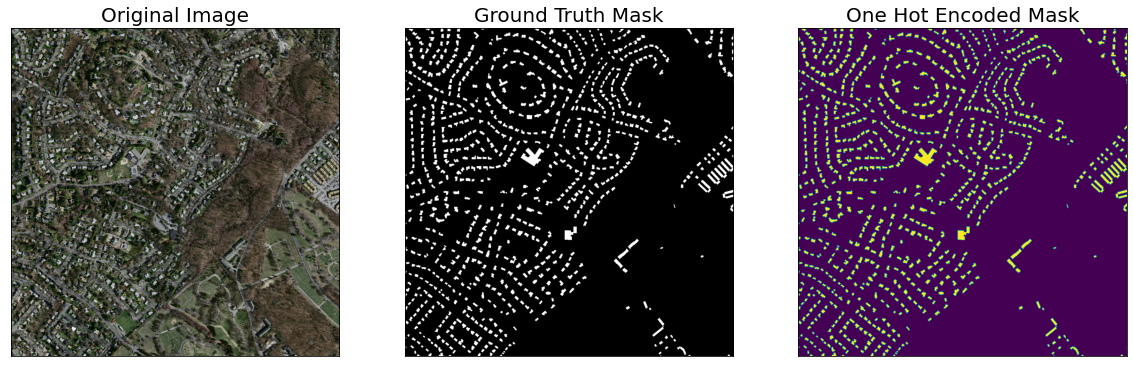

In [8]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values = select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

**Data Augmentation**

In [9]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height = 256, width = 256, always_apply = True),
        album.OneOf(
            [
                album.HorizontalFlip(p = 1),
                album.VerticalFlip(p = 1),
                album.RandomRotate90(p = 1),
            ],
            p = 0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height = 1536, min_width = 1536, always_apply = True, border_mode = 0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """
    Construct preprocessing transform    
    
    Arguments:
        preprocessing_fn (callable): data normalization function (can be specific for each pretrained neural network)
    Returns:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image = preprocessing_fn))
    _transform.append(album.Lambda(image = to_tensor, mask = to_tensor))
        
    return album.Compose(_transform)

**Visualizing Augmented Images & Masks**

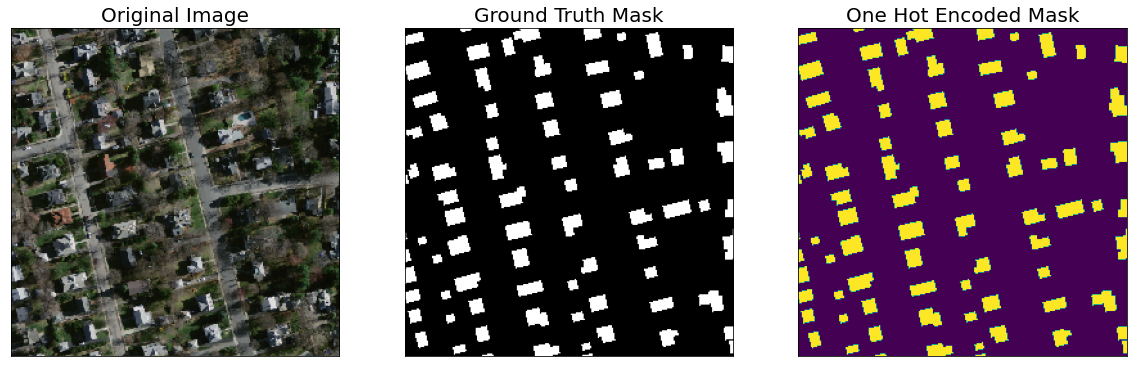

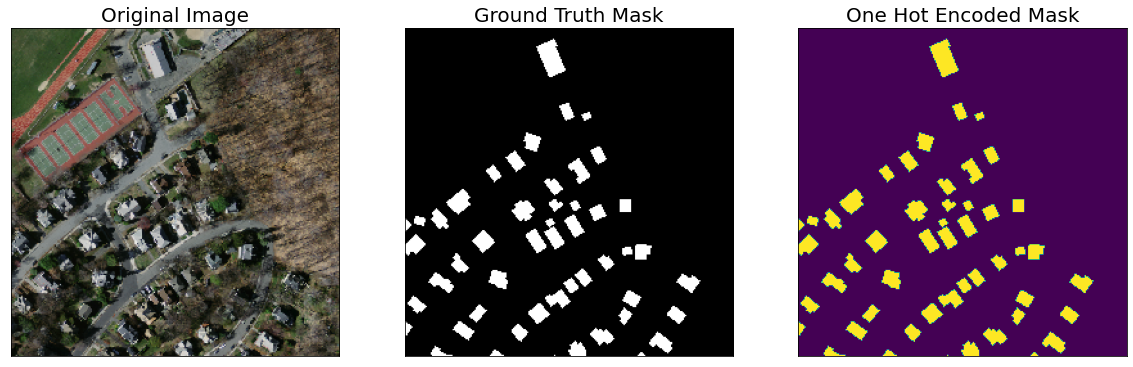

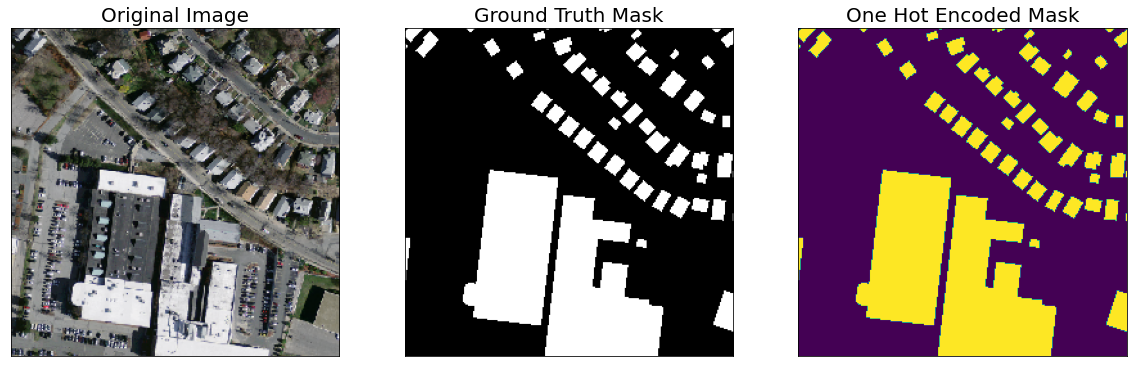

In [10]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation = get_training_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)

# Different augmentations on a random image / mask pair (256 * 256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

**Defining Model**

In [11]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

# Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name = ENCODER, 
    encoder_weights = ENCODER_WEIGHTS, 
    classes = len(CLASSES), 
    activation = ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

**Updates For Albumentations Module In Case Required**

In [22]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-pju9yxx5
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-pju9yxx5
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=81728 sha256=b1d72e4a92b30f66629285f8fc9808202e2f4fc0ae4bab1e2310b9ccc0632b62
  Stored in directory: /tmp/pip-ephem-wheel-cache-65folefy/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


**Training & Validation Data Loading**

In [12]:
# Get train and validation dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    class_rgb_values = select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    class_rgb_values = select_class_rgb_values,
)

# Get train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 12)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False, num_workers = 4)

**Setting Hyperparameters**

In [13]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set number of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function
loss = smp.utils.losses.DiceLoss()

# Define metrics
metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

# Define optimizer
optimizer = torch.optim.Adam([ 
    dict(params = model.parameters(), lr = 0.0001),
])

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0 = 1, T_mult = 2, eta_min = 5e-5,
)

# Load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location = DEVICE)

In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    device = DEVICE,
    verbose = True,
)

**Training Model**

In [15]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, dice_loss - 0.4909, iou_score - 0.4232]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, dice_loss - 0.4082, iou_score - 0.5481]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, dice_loss - 0.3635, iou_score - 0.626]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, dice_loss - 0.3417, iou_score - 0.6623]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, dice_loss - 0.3113, iou_score - 0.7126]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, dice_loss - 0.2899, iou_score - 0.7394]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, dice_loss - 0.2674, iou_score - 0.7802]
Model saved!

Epoch: 7
valid: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, dice_loss - 0.2691, iou_score - 0.7618]

Epoch: 8
valid: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, dice_loss - 0.2594, iou

**Prediction On Test Data**

In [16]:
# Load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location = DEVICE)
    print('Loaded UNet model from this run.')

# Load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location = DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


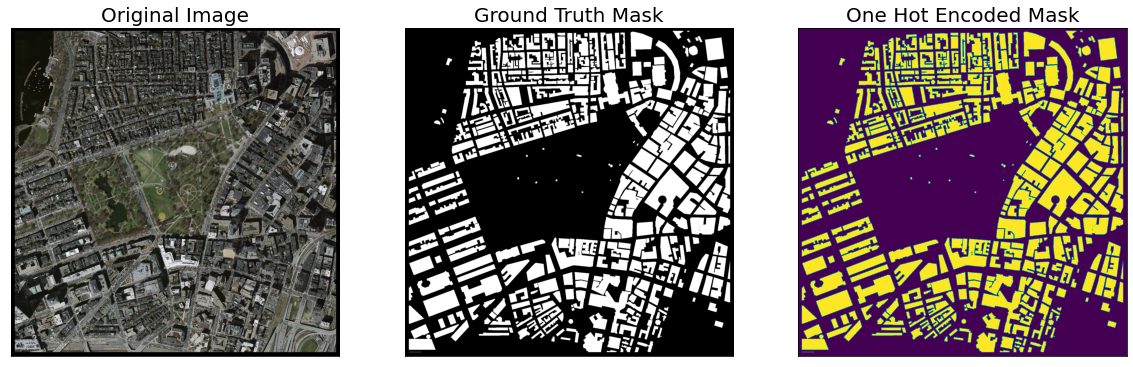

In [17]:
# Create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    class_rgb_values = select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# Test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation = get_validation_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

# Get a random test image / mask index
random_idx = random.randint(0, len(test_dataset_vis) - 1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536 * 1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose convolution operations).

In [18]:
# Center crop padded image / mask to original image dimensions
def crop_image(image, target_image_dims = [1500, 1500, 3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [19]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

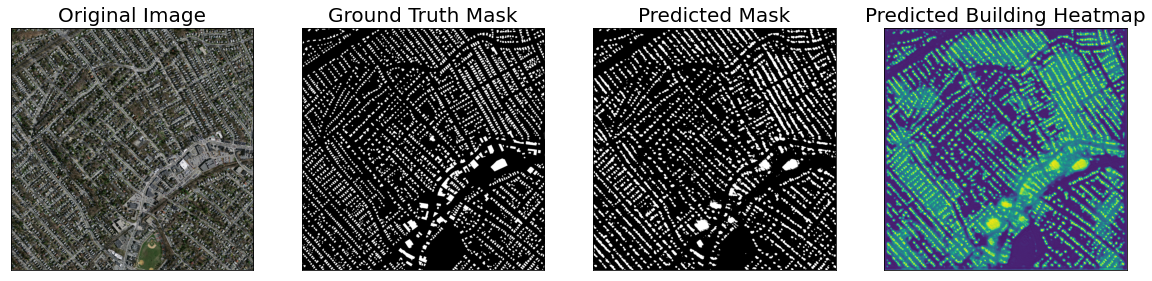

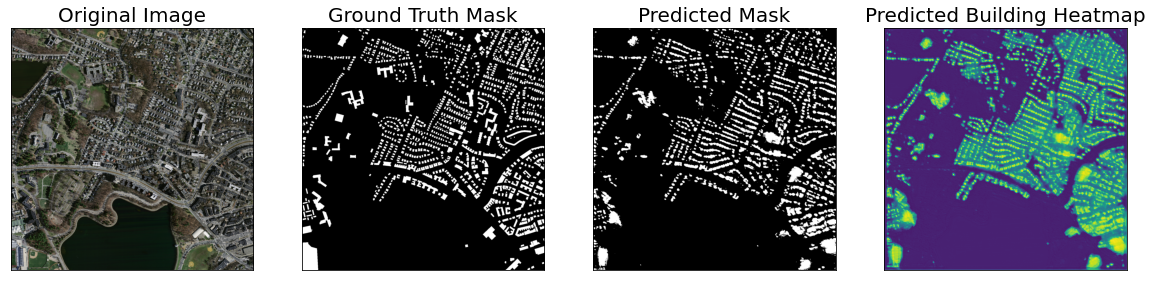

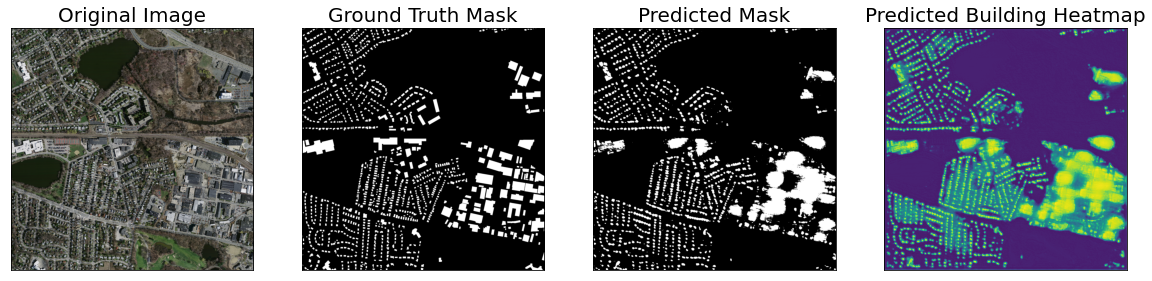

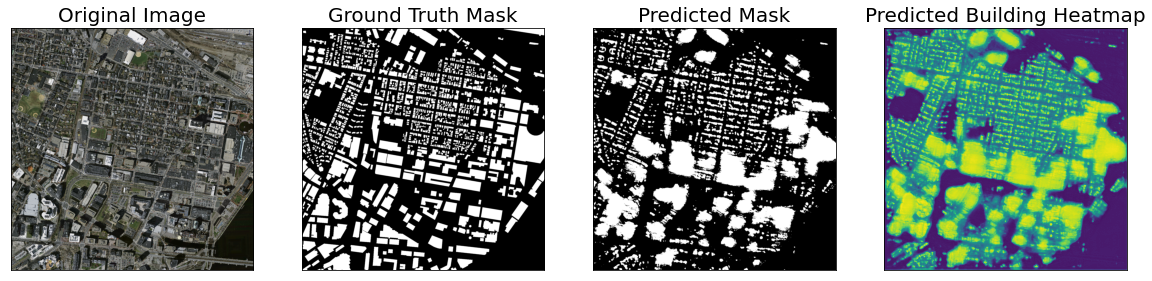

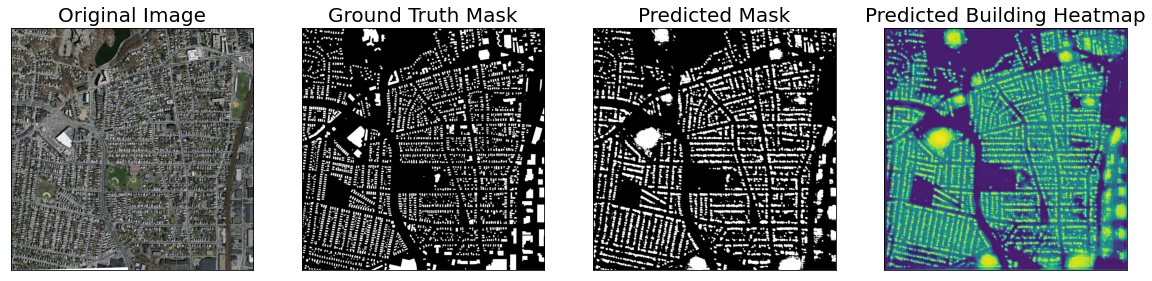

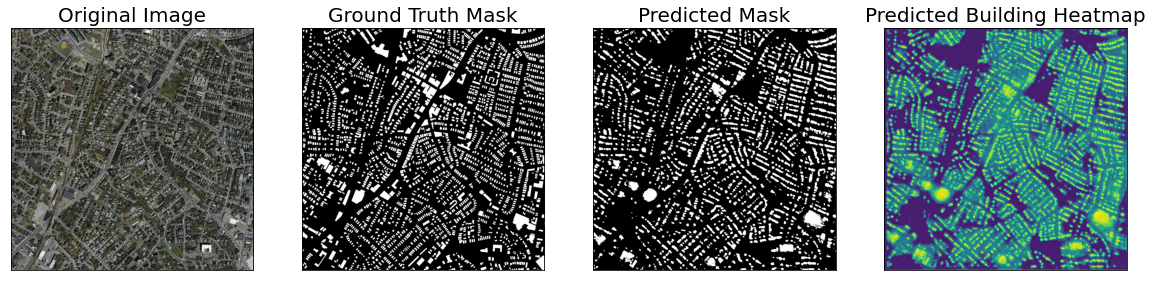

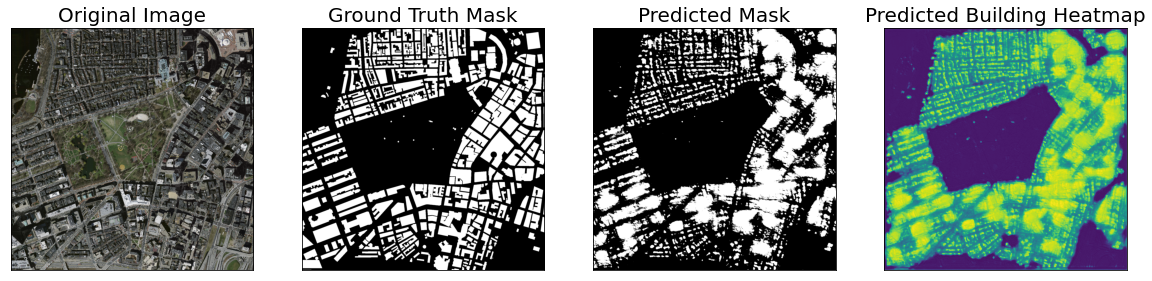

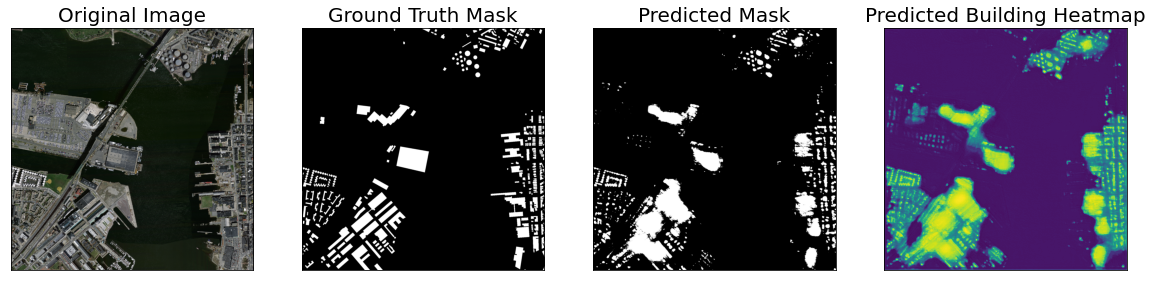

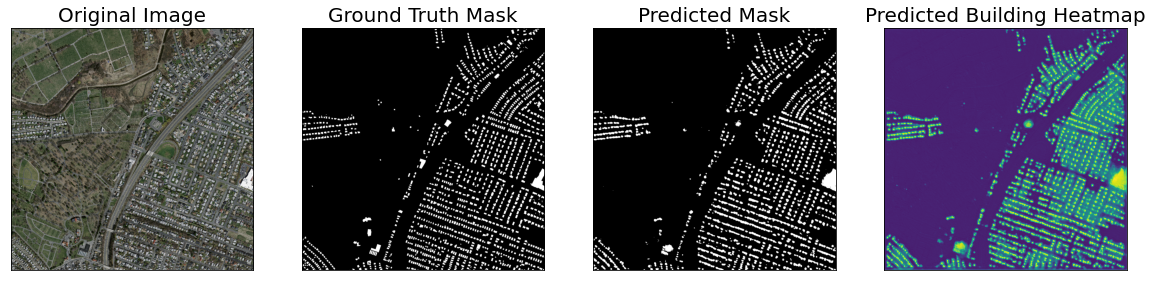

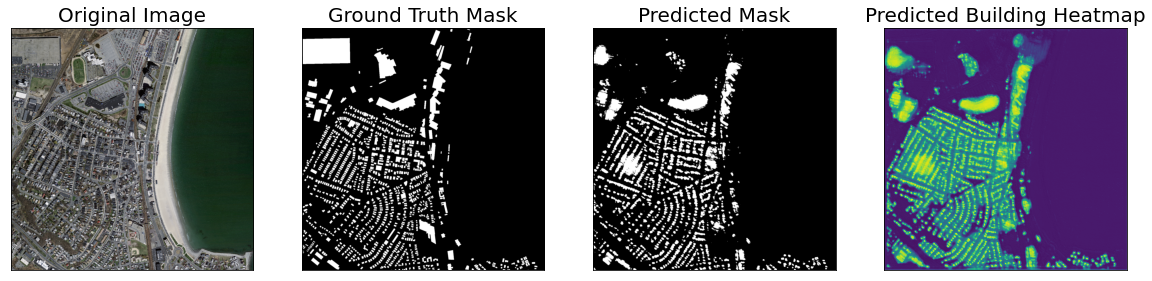

In [20]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask, (1, 2, 0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

**Model Evaluation On Test Dataset**

In [21]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss, 
    metrics = metrics, 
    device = DEVICE,
    verbose = True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s, dice_loss - 0.2879, iou_score - 0.7186]
Evaluation on Test Data: 
Mean IoU Score: 0.7186
Mean Dice Loss: 0.2879


**Dice Loss & IoU Metrics**

In [22]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2  ...         7         8         9
dice_loss  0.419691  0.390634  0.363983  ...  0.291779  0.282080  0.277719
iou_score  0.526649  0.584235  0.632372  ...  0.724910  0.730638  0.731864

[2 rows x 10 columns]

**Plotting The Performance Metrics**

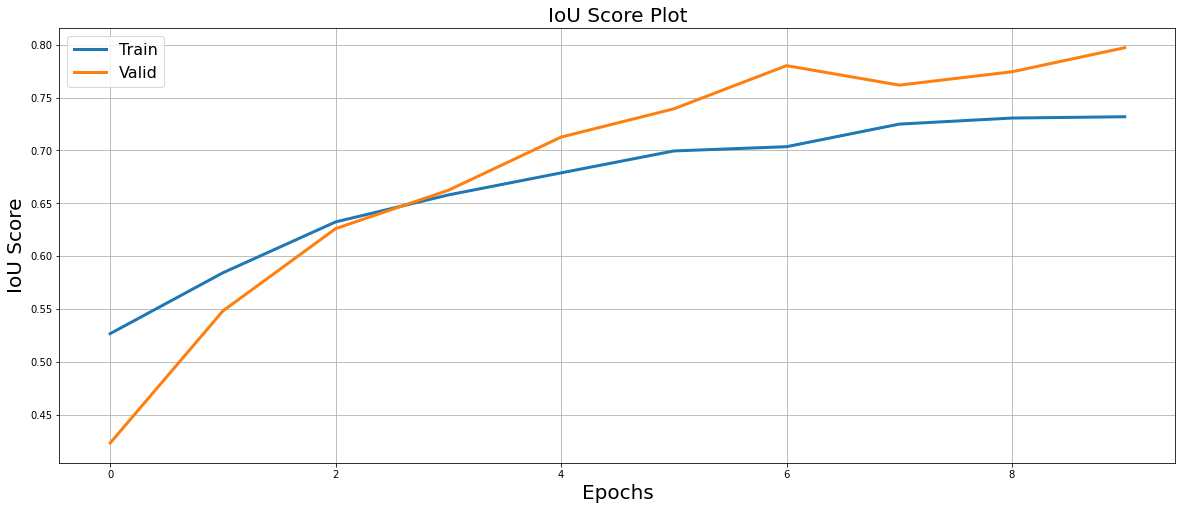

In [23]:
plt.figure(figsize = (20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw = 3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw = 3, label = 'Valid')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('IoU Score', fontsize = 20)
plt.title('IoU Score Plot', fontsize = 20)
plt.legend(loc = 'best', fontsize = 16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

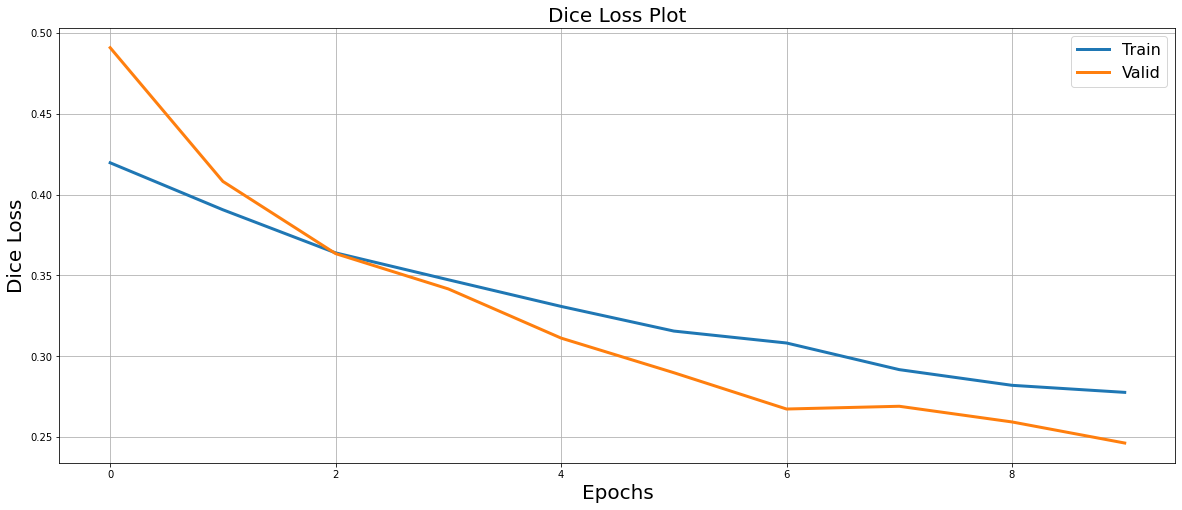

In [24]:
plt.figure(figsize = (20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw = 3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw = 3, label = 'Valid')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Dice Loss', fontsize = 20)
plt.title('Dice Loss Plot', fontsize = 20)
plt.legend(loc = 'best', fontsize = 16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()